In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
train_datagen=ImageDataGenerator(
                               rotation_range=30,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.01,
                               zoom_range=[0.8, 1.25],
                               horizontal_flip=True,
                               vertical_flip=False,
                               fill_mode='reflect',
                               data_format='channels_last',
                               brightness_range=[0.5, 1.5]) #included in our dependencies

test_datagen = ImageDataGenerator(
                               rotation_range=30,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.01,
                               zoom_range=[0.8, 1.25],
                               horizontal_flip=True,
                               vertical_flip=False,
                               fill_mode='reflect',
                               data_format='channels_last',
                               brightness_range=[0.5, 1.5]) #included in our dependencies

In [4]:
image_size = (128,128)
batch_size = 10

training_data_dir = r'C:\DeepLearning\RealImages\Train'
validation_data_dir = r'C:\DeepLearning\RealImages\Validation'

train_generator=train_datagen.flow_from_directory(training_data_dir,
                                                 target_size=image_size,
                                                 color_mode='rgb',
                                                 batch_size=batch_size,
                                                 class_mode='categorical',
                                                 shuffle=True)

validation_generator = test_datagen.flow_from_directory(
                                        validation_data_dir,
                                         target_size=image_size,
                                         color_mode='rgb',
                                        class_mode = "categorical")

Found 7795 images belonging to 100 classes.
Found 2803 images belonging to 100 classes.


In [5]:
x_batch, y_batch = next(train_generator)

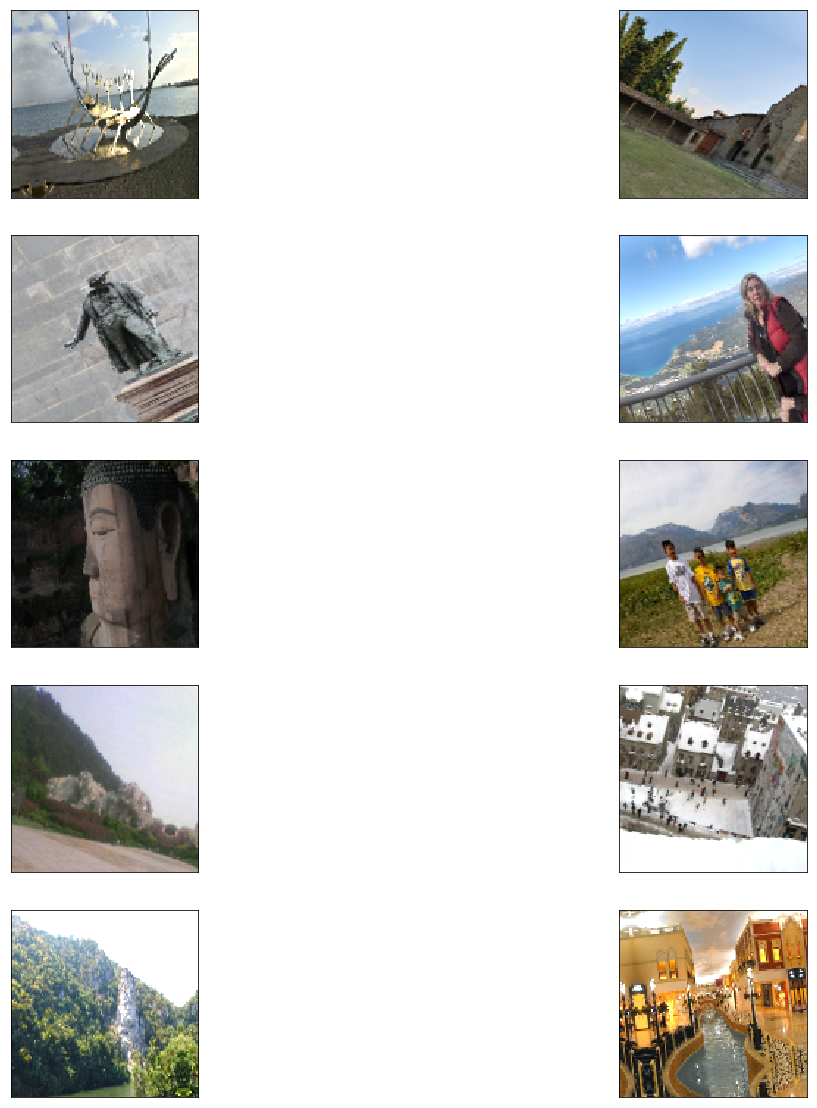

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20, 20))
for i in range(10):
    plt.subplot(5,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image = x_batch[i]
    image= image.astype(int)
    plt.imshow(image)

In [7]:
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

In [8]:
base_model = applications.VGG16(weights = "imagenet", include_top=False, input_shape = (image_size[0], image_size[1], 3))

In [9]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [10]:
for layer in base_model.layers[:]:
    print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [11]:
for layer in base_model.layers[:]:
    layer.trainable = False

In [12]:
classCount = 100

x=base_model.output
x = Dropout(0.3, input_shape=(4,4,512))(x)
x=Conv2D(input_shape=(4,4,512), filters=512, kernel_size=[3,3],activation='tanh',padding='same')(x)
x=Conv2D(input_shape=(4,4,512), filters=512, kernel_size=[3,3],activation='tanh',padding='same')(x)
x=Conv2D(input_shape=(4,4,512), filters=512, kernel_size=[3,3],activation='tanh',padding='same')(x)
x=MaxPooling2D(input_shape=(4,4,512),pool_size=(2,2),strides=(2,2))(x)
x = Dropout(0.3, input_shape=(4,4,512))(x)
x=Flatten()(x)
preds=Dense(classCount,activation='softmax')(x) #final layer with softmax activation

model_final=Model(inputs=base_model.input,outputs=preds)

In [13]:
model_final.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [14]:
model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.001, momentum=0.9), metrics=["accuracy"])

In [15]:
step_size_train=train_generator.n//train_generator.batch_size
print(step_size_train)

779


In [16]:
class LossAccHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.accuracy = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.accuracy.append(logs.get('acc'))
        
history = LossAccHistory()

In [ ]:
model_final.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   validation_data = validation_generator,
                   epochs=10
                   ,callbacks = [history])

import matplotlib.pyplot as plt
x = range(0, len(history.losses))
plt.plot(x, history.losses)
plt.plot(x, history.accuracy)
plt.xlabel('batches')
plt.title('Loss and Accuracy')
plt.legend(['losses', 'accuracy'])

early = EarlyStopping(monitor='val_acc', min_delta=0, patience=3, verbose=1, mode='auto')

import time

networkfileName = "D:\DeepLearningH5\\vgg16_{}.h5".format(int(time.time()))
checkpoint = ModelCheckpoint(networkfileName, monitor='val_acc', verbose=1,
                             save_best_only=True, save_weights_only=False, mode='auto', period=1)

history = LossAccHistory()
model_final.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   validation_data = validation_generator,
                   epochs=5
                   ,callbacks = [history, checkpoint, early])

import matplotlib.pyplot as plt
x = range(0, len(history.losses))
plt.plot(x, history.losses)
plt.plot(x, history.accuracy)
plt.xlabel('batches')
plt.title('Loss and Accuracy')
plt.legend(['losses', 'accuracy'])

Epoch 1/10
779/779 [==============================] - 954s 1s/step - loss: 2.9894 - acc: 0.3080 - val_loss: 1.9113 - val_acc: 0.5309
Epoch 2/10
779/779 [==============================] - 958s 1s/step - loss: 1.7133 - acc: 0.5674 - val_loss: 1.4725 - val_acc: 0.6215
Epoch 3/10
779/779 [==============================] - 957s 1s/step - loss: 1.4084 - acc: 0.6345 - val_loss: 1.2564 - val_acc: 0.6621
Epoch 4/10
779/779 [==============================] - 957s 1s/step - loss: 1.2281 - acc: 0.6769 - val_loss: 1.1611 - val_acc: 0.6957
Epoch 5/10
779/779 [==============================] - 957s 1s/step - loss: 1.1249 - acc: 0.6879 - val_loss: 1.0782 - val_acc: 0.7182
Epoch 6/10
779/779 [==============================] - 958s 1s/step - loss: 1.0584 - acc: 0.7099 - val_loss: 1.0625 - val_acc: 0.7207
Epoch 7/10
779/779 [==============================] - 958s 1s/step - loss: 0.9956 - acc: 0.7234 - val_loss: 0.9966 - val_acc: 0.7371
Epoch 8/10
779/779 [==============================] - 958s 1s/step - 

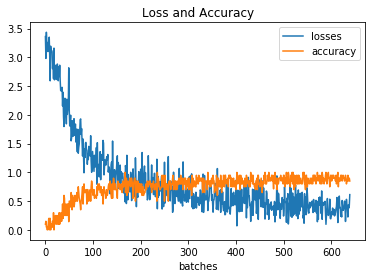

Epoch 1/5
79/80 [============================>.] - ETA: 1s - loss: 0.3662 - acc: 0.8937
Epoch 00001: val_acc improved from -inf to 0.89587, saving model to C:\ML666\vgg16_v2.h5
80/80 [==============================] - 192s 2s/step - loss: 0.3666 - acc: 0.8937 - val_loss: 0.3541 - val_acc: 0.8959
Epoch 2/5
79/80 [============================>.] - ETA: 1s - loss: 0.3487 - acc: 0.8944
Epoch 00002: val_acc improved from 0.89587 to 0.90305, saving model to C:\ML666\vgg16_v2.h5
80/80 [==============================] - 192s 2s/step - loss: 0.3499 - acc: 0.8945 - val_loss: 0.3315 - val_acc: 0.9031
Epoch 3/5
79/80 [============================>.] - ETA: 1s - loss: 0.3320 - acc: 0.8968
Epoch 00003: val_acc did not improve from 0.90305
80/80 [==============================] - 194s 2s/step - loss: 0.3296 - acc: 0.8981 - val_loss: 0.3580 - val_acc: 0.8941
Epoch 4/5
79/80 [============================>.] - ETA: 1s - loss: 0.2915 - acc: 0.9052
Epoch 00004: val_acc did not improve from 0.90305
80/80 [

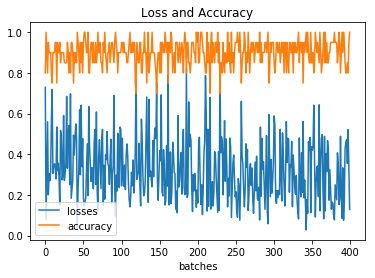

In [33]:
import matplotlib.pyplot as plt
x = range(0, len(history.losses))
plt.plot(x, history.losses)
plt.plot(x, history.accuracy)
plt.xlabel('batches')
plt.title('Loss and Accuracy')
plt.legend(['losses', 'accuracy'])

In [1]:
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# The directory of KNN train data
data_dir = r'C:\DeepLearning\IndexNew'

# The neural network model into base_model
base_model = load_model('D:\DeepLearningH5\\vgg16_1549482952.h5')

# Cut the customized layers from the read resnet algorithm
x=base_model.get_layer('block5_pool').output

# Eport network to one dimension
vector=Flatten()(x)

# Make the model with the whole network as input and the vector as output
model = Model(inputs=base_model.input, outputs=vector)

datagen = ImageDataGenerator()     # Creating the Data generator

# Generator from the images
generator = datagen.flow_from_directory(
        data_dir,
        target_size=(128, 128),
        batch_size=1,
        class_mode='categorical',  # only data, no labels
        shuffle=False)  # keep data in same order as label

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Found 28785 images belonging to 3 classes.


In [ ]:
import numpy as np

imgsList = []
proccImgs = []
labels = []

# For each image in the generator
for i in range(generator.n):
    (img, lbl) = generator.next();
    
    # Adding the image to the list of images
    imgsList.append(img)
    
    # Adding the proccessed images to the list of processed imaged
    proccImgs.append(np.reshape(model.predict_on_batch(img), -1))
    
    # Adding the image labels to list of labels
    labels.append(np.argmax(lbl))
    
    print("Adding " + str(i) + " image")
    
print(labels)

Adding 0 image
Adding 1 image
Adding 2 image
Adding 3 image
Adding 4 image
Adding 5 image
Adding 6 image
Adding 7 image
Adding 8 image
Adding 9 image
Adding 10 image
Adding 11 image
Adding 12 image
Adding 13 image
Adding 14 image
Adding 15 image
Adding 16 image
Adding 17 image
Adding 18 image
Adding 19 image
Adding 20 image
Adding 21 image
Adding 22 image
Adding 23 image
Adding 24 image
Adding 25 image
Adding 26 image
Adding 27 image
Adding 28 image
Adding 29 image
Adding 30 image
Adding 31 image
Adding 32 image
Adding 33 image
Adding 34 image
Adding 35 image
Adding 36 image
Adding 37 image
Adding 38 image
Adding 39 image
Adding 40 image
Adding 41 image
Adding 42 image
Adding 43 image
Adding 44 image
Adding 45 image
Adding 46 image
Adding 47 image
Adding 48 image
Adding 49 image
Adding 50 image
Adding 51 image
Adding 52 image
Adding 53 image
Adding 54 image
Adding 55 image
Adding 56 image
Adding 57 image
Adding 58 image
Adding 59 image
Adding 60 image
Adding 61 image
Adding 62 image
Ad

Adding 489 image
Adding 490 image
Adding 491 image
Adding 492 image
Adding 493 image
Adding 494 image
Adding 495 image
Adding 496 image
Adding 497 image
Adding 498 image
Adding 499 image
Adding 500 image
Adding 501 image
Adding 502 image
Adding 503 image
Adding 504 image
Adding 505 image
Adding 506 image
Adding 507 image
Adding 508 image
Adding 509 image
Adding 510 image
Adding 511 image
Adding 512 image
Adding 513 image
Adding 514 image
Adding 515 image
Adding 516 image
Adding 517 image
Adding 518 image
Adding 519 image
Adding 520 image
Adding 521 image
Adding 522 image
Adding 523 image
Adding 524 image
Adding 525 image
Adding 526 image
Adding 527 image
Adding 528 image
Adding 529 image
Adding 530 image
Adding 531 image
Adding 532 image
Adding 533 image
Adding 534 image
Adding 535 image
Adding 536 image
Adding 537 image
Adding 538 image
Adding 539 image
Adding 540 image
Adding 541 image
Adding 542 image
Adding 543 image
Adding 544 image
Adding 545 image
Adding 546 image
Adding 547 ima

Adding 971 image
Adding 972 image
Adding 973 image
Adding 974 image
Adding 975 image
Adding 976 image
Adding 977 image
Adding 978 image
Adding 979 image
Adding 980 image
Adding 981 image
Adding 982 image
Adding 983 image
Adding 984 image
Adding 985 image
Adding 986 image
Adding 987 image
Adding 988 image
Adding 989 image
Adding 990 image
Adding 991 image
Adding 992 image
Adding 993 image
Adding 994 image
Adding 995 image
Adding 996 image
Adding 997 image
Adding 998 image
Adding 999 image
Adding 1000 image
Adding 1001 image
Adding 1002 image
Adding 1003 image
Adding 1004 image
Adding 1005 image
Adding 1006 image
Adding 1007 image
Adding 1008 image
Adding 1009 image
Adding 1010 image
Adding 1011 image
Adding 1012 image
Adding 1013 image
Adding 1014 image
Adding 1015 image
Adding 1016 image
Adding 1017 image
Adding 1018 image
Adding 1019 image
Adding 1020 image
Adding 1021 image
Adding 1022 image
Adding 1023 image
Adding 1024 image
Adding 1025 image
Adding 1026 image
Adding 1027 image
Add

Adding 1428 image
Adding 1429 image
Adding 1430 image
Adding 1431 image
Adding 1432 image
Adding 1433 image
Adding 1434 image
Adding 1435 image
Adding 1436 image
Adding 1437 image
Adding 1438 image
Adding 1439 image
Adding 1440 image
Adding 1441 image
Adding 1442 image
Adding 1443 image
Adding 1444 image
Adding 1445 image
Adding 1446 image
Adding 1447 image
Adding 1448 image
Adding 1449 image
Adding 1450 image
Adding 1451 image
Adding 1452 image
Adding 1453 image
Adding 1454 image
Adding 1455 image
Adding 1456 image
Adding 1457 image
Adding 1458 image
Adding 1459 image
Adding 1460 image
Adding 1461 image
Adding 1462 image
Adding 1463 image
Adding 1464 image
Adding 1465 image
Adding 1466 image
Adding 1467 image
Adding 1468 image
Adding 1469 image
Adding 1470 image
Adding 1471 image
Adding 1472 image
Adding 1473 image
Adding 1474 image
Adding 1475 image
Adding 1476 image
Adding 1477 image
Adding 1478 image
Adding 1479 image
Adding 1480 image
Adding 1481 image
Adding 1482 image
Adding 148

Adding 1884 image
Adding 1885 image
Adding 1886 image
Adding 1887 image
Adding 1888 image
Adding 1889 image
Adding 1890 image
Adding 1891 image
Adding 1892 image
Adding 1893 image
Adding 1894 image
Adding 1895 image
Adding 1896 image
Adding 1897 image
Adding 1898 image
Adding 1899 image
Adding 1900 image
Adding 1901 image
Adding 1902 image
Adding 1903 image
Adding 1904 image
Adding 1905 image
Adding 1906 image
Adding 1907 image
Adding 1908 image
Adding 1909 image
Adding 1910 image
Adding 1911 image
Adding 1912 image
Adding 1913 image
Adding 1914 image
Adding 1915 image
Adding 1916 image
Adding 1917 image
Adding 1918 image
Adding 1919 image
Adding 1920 image
Adding 1921 image
Adding 1922 image
Adding 1923 image
Adding 1924 image
Adding 1925 image
Adding 1926 image
Adding 1927 image
Adding 1928 image
Adding 1929 image
Adding 1930 image
Adding 1931 image
Adding 1932 image
Adding 1933 image
Adding 1934 image
Adding 1935 image
Adding 1936 image
Adding 1937 image
Adding 1938 image
Adding 193

Adding 2340 image
Adding 2341 image
Adding 2342 image
Adding 2343 image
Adding 2344 image
Adding 2345 image
Adding 2346 image
Adding 2347 image
Adding 2348 image
Adding 2349 image
Adding 2350 image
Adding 2351 image
Adding 2352 image
Adding 2353 image
Adding 2354 image
Adding 2355 image
Adding 2356 image
Adding 2357 image
Adding 2358 image
Adding 2359 image
Adding 2360 image
Adding 2361 image
Adding 2362 image
Adding 2363 image
Adding 2364 image
Adding 2365 image
Adding 2366 image
Adding 2367 image
Adding 2368 image
Adding 2369 image
Adding 2370 image
Adding 2371 image
Adding 2372 image
Adding 2373 image
Adding 2374 image
Adding 2375 image
Adding 2376 image
Adding 2377 image
Adding 2378 image
Adding 2379 image
Adding 2380 image
Adding 2381 image
Adding 2382 image
Adding 2383 image
Adding 2384 image
Adding 2385 image
Adding 2386 image
Adding 2387 image
Adding 2388 image
Adding 2389 image
Adding 2390 image
Adding 2391 image
Adding 2392 image
Adding 2393 image
Adding 2394 image
Adding 239

Adding 2796 image
Adding 2797 image
Adding 2798 image
Adding 2799 image
Adding 2800 image
Adding 2801 image
Adding 2802 image
Adding 2803 image
Adding 2804 image
Adding 2805 image
Adding 2806 image
Adding 2807 image
Adding 2808 image
Adding 2809 image
Adding 2810 image
Adding 2811 image
Adding 2812 image
Adding 2813 image
Adding 2814 image
Adding 2815 image
Adding 2816 image
Adding 2817 image
Adding 2818 image
Adding 2819 image
Adding 2820 image
Adding 2821 image
Adding 2822 image
Adding 2823 image
Adding 2824 image
Adding 2825 image
Adding 2826 image
Adding 2827 image
Adding 2828 image
Adding 2829 image
Adding 2830 image
Adding 2831 image
Adding 2832 image
Adding 2833 image
Adding 2834 image
Adding 2835 image
Adding 2836 image
Adding 2837 image
Adding 2838 image
Adding 2839 image
Adding 2840 image
Adding 2841 image
Adding 2842 image
Adding 2843 image
Adding 2844 image
Adding 2845 image
Adding 2846 image
Adding 2847 image
Adding 2848 image
Adding 2849 image
Adding 2850 image
Adding 285

Adding 3252 image
Adding 3253 image
Adding 3254 image
Adding 3255 image
Adding 3256 image
Adding 3257 image
Adding 3258 image
Adding 3259 image
Adding 3260 image
Adding 3261 image
Adding 3262 image
Adding 3263 image
Adding 3264 image
Adding 3265 image
Adding 3266 image
Adding 3267 image
Adding 3268 image
Adding 3269 image
Adding 3270 image
Adding 3271 image
Adding 3272 image
Adding 3273 image
Adding 3274 image
Adding 3275 image
Adding 3276 image
Adding 3277 image
Adding 3278 image
Adding 3279 image
Adding 3280 image
Adding 3281 image
Adding 3282 image
Adding 3283 image
Adding 3284 image
Adding 3285 image
Adding 3286 image
Adding 3287 image
Adding 3288 image
Adding 3289 image
Adding 3290 image
Adding 3291 image
Adding 3292 image
Adding 3293 image
Adding 3294 image
Adding 3295 image
Adding 3296 image
Adding 3297 image
Adding 3298 image
Adding 3299 image
Adding 3300 image
Adding 3301 image
Adding 3302 image
Adding 3303 image
Adding 3304 image
Adding 3305 image
Adding 3306 image
Adding 330

Adding 3708 image
Adding 3709 image
Adding 3710 image
Adding 3711 image
Adding 3712 image
Adding 3713 image
Adding 3714 image
Adding 3715 image
Adding 3716 image
Adding 3717 image
Adding 3718 image
Adding 3719 image
Adding 3720 image
Adding 3721 image
Adding 3722 image
Adding 3723 image
Adding 3724 image
Adding 3725 image
Adding 3726 image
Adding 3727 image
Adding 3728 image
Adding 3729 image
Adding 3730 image
Adding 3731 image
Adding 3732 image
Adding 3733 image
Adding 3734 image
Adding 3735 image
Adding 3736 image
Adding 3737 image
Adding 3738 image
Adding 3739 image
Adding 3740 image
Adding 3741 image
Adding 3742 image
Adding 3743 image
Adding 3744 image
Adding 3745 image
Adding 3746 image
Adding 3747 image
Adding 3748 image
Adding 3749 image
Adding 3750 image
Adding 3751 image
Adding 3752 image
Adding 3753 image
Adding 3754 image
Adding 3755 image
Adding 3756 image
Adding 3757 image
Adding 3758 image
Adding 3759 image
Adding 3760 image
Adding 3761 image
Adding 3762 image
Adding 376

Adding 4164 image
Adding 4165 image
Adding 4166 image
Adding 4167 image
Adding 4168 image
Adding 4169 image
Adding 4170 image
Adding 4171 image
Adding 4172 image
Adding 4173 image
Adding 4174 image
Adding 4175 image
Adding 4176 image
Adding 4177 image
Adding 4178 image
Adding 4179 image
Adding 4180 image
Adding 4181 image
Adding 4182 image
Adding 4183 image
Adding 4184 image
Adding 4185 image
Adding 4186 image
Adding 4187 image
Adding 4188 image
Adding 4189 image
Adding 4190 image
Adding 4191 image
Adding 4192 image
Adding 4193 image
Adding 4194 image
Adding 4195 image
Adding 4196 image
Adding 4197 image
Adding 4198 image
Adding 4199 image
Adding 4200 image
Adding 4201 image
Adding 4202 image
Adding 4203 image
Adding 4204 image
Adding 4205 image
Adding 4206 image
Adding 4207 image
Adding 4208 image
Adding 4209 image
Adding 4210 image
Adding 4211 image
Adding 4212 image
Adding 4213 image
Adding 4214 image
Adding 4215 image
Adding 4216 image
Adding 4217 image
Adding 4218 image
Adding 421

Adding 4620 image
Adding 4621 image
Adding 4622 image
Adding 4623 image
Adding 4624 image
Adding 4625 image
Adding 4626 image
Adding 4627 image
Adding 4628 image
Adding 4629 image
Adding 4630 image
Adding 4631 image
Adding 4632 image
Adding 4633 image
Adding 4634 image
Adding 4635 image
Adding 4636 image
Adding 4637 image
Adding 4638 image
Adding 4639 image
Adding 4640 image
Adding 4641 image
Adding 4642 image
Adding 4643 image
Adding 4644 image
Adding 4645 image
Adding 4646 image
Adding 4647 image
Adding 4648 image
Adding 4649 image
Adding 4650 image
Adding 4651 image
Adding 4652 image
Adding 4653 image
Adding 4654 image
Adding 4655 image
Adding 4656 image
Adding 4657 image
Adding 4658 image
Adding 4659 image
Adding 4660 image
Adding 4661 image
Adding 4662 image
Adding 4663 image
Adding 4664 image
Adding 4665 image
Adding 4666 image
Adding 4667 image
Adding 4668 image
Adding 4669 image
Adding 4670 image
Adding 4671 image
Adding 4672 image
Adding 4673 image
Adding 4674 image
Adding 467

Adding 5076 image
Adding 5077 image
Adding 5078 image
Adding 5079 image
Adding 5080 image
Adding 5081 image
Adding 5082 image
Adding 5083 image
Adding 5084 image
Adding 5085 image
Adding 5086 image
Adding 5087 image
Adding 5088 image
Adding 5089 image
Adding 5090 image
Adding 5091 image
Adding 5092 image
Adding 5093 image
Adding 5094 image
Adding 5095 image
Adding 5096 image
Adding 5097 image
Adding 5098 image
Adding 5099 image
Adding 5100 image
Adding 5101 image
Adding 5102 image
Adding 5103 image
Adding 5104 image
Adding 5105 image
Adding 5106 image
Adding 5107 image
Adding 5108 image
Adding 5109 image
Adding 5110 image
Adding 5111 image
Adding 5112 image
Adding 5113 image
Adding 5114 image
Adding 5115 image
Adding 5116 image
Adding 5117 image
Adding 5118 image
Adding 5119 image
Adding 5120 image
Adding 5121 image
Adding 5122 image
Adding 5123 image
Adding 5124 image
Adding 5125 image
Adding 5126 image
Adding 5127 image
Adding 5128 image
Adding 5129 image
Adding 5130 image
Adding 513

Adding 5532 image
Adding 5533 image
Adding 5534 image
Adding 5535 image
Adding 5536 image
Adding 5537 image
Adding 5538 image
Adding 5539 image
Adding 5540 image
Adding 5541 image
Adding 5542 image
Adding 5543 image
Adding 5544 image
Adding 5545 image
Adding 5546 image
Adding 5547 image
Adding 5548 image
Adding 5549 image
Adding 5550 image
Adding 5551 image
Adding 5552 image
Adding 5553 image
Adding 5554 image
Adding 5555 image
Adding 5556 image
Adding 5557 image
Adding 5558 image
Adding 5559 image
Adding 5560 image
Adding 5561 image
Adding 5562 image
Adding 5563 image
Adding 5564 image
Adding 5565 image
Adding 5566 image
Adding 5567 image
Adding 5568 image
Adding 5569 image
Adding 5570 image
Adding 5571 image
Adding 5572 image
Adding 5573 image
Adding 5574 image
Adding 5575 image
Adding 5576 image
Adding 5577 image
Adding 5578 image
Adding 5579 image
Adding 5580 image
Adding 5581 image
Adding 5582 image
Adding 5583 image
Adding 5584 image
Adding 5585 image
Adding 5586 image
Adding 558

Adding 5989 image
Adding 5990 image
Adding 5991 image
Adding 5992 image
Adding 5993 image
Adding 5994 image
Adding 5995 image
Adding 5996 image
Adding 5997 image
Adding 5998 image
Adding 5999 image
Adding 6000 image
Adding 6001 image
Adding 6002 image
Adding 6003 image
Adding 6004 image
Adding 6005 image
Adding 6006 image
Adding 6007 image
Adding 6008 image
Adding 6009 image
Adding 6010 image
Adding 6011 image
Adding 6012 image
Adding 6013 image
Adding 6014 image
Adding 6015 image
Adding 6016 image
Adding 6017 image
Adding 6018 image
Adding 6019 image
Adding 6020 image
Adding 6021 image
Adding 6022 image
Adding 6023 image
Adding 6024 image
Adding 6025 image
Adding 6026 image
Adding 6027 image
Adding 6028 image
Adding 6029 image
Adding 6030 image
Adding 6031 image
Adding 6032 image
Adding 6033 image
Adding 6034 image
Adding 6035 image
Adding 6036 image
Adding 6037 image
Adding 6038 image
Adding 6039 image
Adding 6040 image
Adding 6041 image
Adding 6042 image
Adding 6043 image
Adding 604

Adding 6446 image
Adding 6447 image
Adding 6448 image
Adding 6449 image
Adding 6450 image
Adding 6451 image
Adding 6452 image
Adding 6453 image
Adding 6454 image
Adding 6455 image
Adding 6456 image
Adding 6457 image
Adding 6458 image
Adding 6459 image
Adding 6460 image
Adding 6461 image
Adding 6462 image
Adding 6463 image
Adding 6464 image
Adding 6465 image
Adding 6466 image
Adding 6467 image
Adding 6468 image
Adding 6469 image
Adding 6470 image
Adding 6471 image
Adding 6472 image
Adding 6473 image
Adding 6474 image
Adding 6475 image
Adding 6476 image
Adding 6477 image
Adding 6478 image
Adding 6479 image
Adding 6480 image
Adding 6481 image
Adding 6482 image
Adding 6483 image
Adding 6484 image
Adding 6485 image
Adding 6486 image
Adding 6487 image
Adding 6488 image
Adding 6489 image
Adding 6490 image
Adding 6491 image
Adding 6492 image
Adding 6493 image
Adding 6494 image
Adding 6495 image
Adding 6496 image
Adding 6497 image
Adding 6498 image
Adding 6499 image
Adding 6500 image
Adding 650

Adding 6903 image
Adding 6904 image
Adding 6905 image
Adding 6906 image
Adding 6907 image
Adding 6908 image
Adding 6909 image
Adding 6910 image
Adding 6911 image
Adding 6912 image
Adding 6913 image
Adding 6914 image
Adding 6915 image
Adding 6916 image
Adding 6917 image
Adding 6918 image
Adding 6919 image
Adding 6920 image
Adding 6921 image
Adding 6922 image
Adding 6923 image
Adding 6924 image
Adding 6925 image
Adding 6926 image
Adding 6927 image
Adding 6928 image
Adding 6929 image
Adding 6930 image
Adding 6931 image
Adding 6932 image
Adding 6933 image
Adding 6934 image
Adding 6935 image
Adding 6936 image
Adding 6937 image
Adding 6938 image
Adding 6939 image
Adding 6940 image
Adding 6941 image
Adding 6942 image
Adding 6943 image
Adding 6944 image
Adding 6945 image
Adding 6946 image
Adding 6947 image
Adding 6948 image
Adding 6949 image
Adding 6950 image
Adding 6951 image
Adding 6952 image
Adding 6953 image
Adding 6954 image
Adding 6955 image
Adding 6956 image
Adding 6957 image
Adding 695

Adding 7359 image
Adding 7360 image
Adding 7361 image
Adding 7362 image
Adding 7363 image
Adding 7364 image
Adding 7365 image
Adding 7366 image
Adding 7367 image
Adding 7368 image
Adding 7369 image
Adding 7370 image
Adding 7371 image
Adding 7372 image
Adding 7373 image
Adding 7374 image
Adding 7375 image
Adding 7376 image
Adding 7377 image
Adding 7378 image
Adding 7379 image
Adding 7380 image
Adding 7381 image
Adding 7382 image
Adding 7383 image
Adding 7384 image
Adding 7385 image
Adding 7386 image
Adding 7387 image
Adding 7388 image
Adding 7389 image
Adding 7390 image
Adding 7391 image
Adding 7392 image
Adding 7393 image
Adding 7394 image
Adding 7395 image
Adding 7396 image
Adding 7397 image
Adding 7398 image
Adding 7399 image
Adding 7400 image
Adding 7401 image
Adding 7402 image
Adding 7403 image
Adding 7404 image
Adding 7405 image
Adding 7406 image
Adding 7407 image
Adding 7408 image
Adding 7409 image
Adding 7410 image
Adding 7411 image
Adding 7412 image
Adding 7413 image
Adding 741

Adding 7816 image
Adding 7817 image
Adding 7818 image
Adding 7819 image
Adding 7820 image
Adding 7821 image
Adding 7822 image
Adding 7823 image
Adding 7824 image
Adding 7825 image
Adding 7826 image
Adding 7827 image
Adding 7828 image
Adding 7829 image
Adding 7830 image
Adding 7831 image
Adding 7832 image
Adding 7833 image
Adding 7834 image
Adding 7835 image
Adding 7836 image
Adding 7837 image
Adding 7838 image
Adding 7839 image
Adding 7840 image
Adding 7841 image
Adding 7842 image
Adding 7843 image
Adding 7844 image
Adding 7845 image
Adding 7846 image
Adding 7847 image
Adding 7848 image
Adding 7849 image
Adding 7850 image
Adding 7851 image
Adding 7852 image
Adding 7853 image
Adding 7854 image
Adding 7855 image
Adding 7856 image
Adding 7857 image
Adding 7858 image
Adding 7859 image
Adding 7860 image
Adding 7861 image
Adding 7862 image
Adding 7863 image
Adding 7864 image
Adding 7865 image
Adding 7866 image
Adding 7867 image
Adding 7868 image
Adding 7869 image
Adding 7870 image
Adding 787

Adding 8272 image
Adding 8273 image
Adding 8274 image
Adding 8275 image
Adding 8276 image
Adding 8277 image
Adding 8278 image
Adding 8279 image
Adding 8280 image
Adding 8281 image
Adding 8282 image
Adding 8283 image
Adding 8284 image
Adding 8285 image
Adding 8286 image
Adding 8287 image
Adding 8288 image
Adding 8289 image
Adding 8290 image
Adding 8291 image
Adding 8292 image
Adding 8293 image
Adding 8294 image
Adding 8295 image
Adding 8296 image
Adding 8297 image
Adding 8298 image
Adding 8299 image
Adding 8300 image
Adding 8301 image
Adding 8302 image
Adding 8303 image
Adding 8304 image
Adding 8305 image
Adding 8306 image
Adding 8307 image
Adding 8308 image
Adding 8309 image
Adding 8310 image
Adding 8311 image
Adding 8312 image
Adding 8313 image
Adding 8314 image
Adding 8315 image
Adding 8316 image
Adding 8317 image
Adding 8318 image
Adding 8319 image
Adding 8320 image
Adding 8321 image
Adding 8322 image
Adding 8323 image
Adding 8324 image
Adding 8325 image
Adding 8326 image
Adding 832

Adding 8729 image
Adding 8730 image
Adding 8731 image
Adding 8732 image
Adding 8733 image
Adding 8734 image
Adding 8735 image
Adding 8736 image
Adding 8737 image
Adding 8738 image
Adding 8739 image
Adding 8740 image
Adding 8741 image
Adding 8742 image
Adding 8743 image
Adding 8744 image
Adding 8745 image
Adding 8746 image
Adding 8747 image
Adding 8748 image
Adding 8749 image
Adding 8750 image
Adding 8751 image
Adding 8752 image
Adding 8753 image
Adding 8754 image
Adding 8755 image
Adding 8756 image
Adding 8757 image
Adding 8758 image
Adding 8759 image
Adding 8760 image
Adding 8761 image
Adding 8762 image
Adding 8763 image
Adding 8764 image
Adding 8765 image
Adding 8766 image
Adding 8767 image
Adding 8768 image
Adding 8769 image
Adding 8770 image
Adding 8771 image
Adding 8772 image
Adding 8773 image
Adding 8774 image
Adding 8775 image
Adding 8776 image
Adding 8777 image
Adding 8778 image
Adding 8779 image
Adding 8780 image
Adding 8781 image
Adding 8782 image
Adding 8783 image
Adding 878

Adding 9185 image
Adding 9186 image
Adding 9187 image
Adding 9188 image
Adding 9189 image
Adding 9190 image
Adding 9191 image
Adding 9192 image
Adding 9193 image
Adding 9194 image
Adding 9195 image
Adding 9196 image
Adding 9197 image
Adding 9198 image
Adding 9199 image
Adding 9200 image
Adding 9201 image
Adding 9202 image
Adding 9203 image
Adding 9204 image
Adding 9205 image
Adding 9206 image
Adding 9207 image
Adding 9208 image
Adding 9209 image
Adding 9210 image
Adding 9211 image
Adding 9212 image
Adding 9213 image
Adding 9214 image
Adding 9215 image
Adding 9216 image
Adding 9217 image
Adding 9218 image
Adding 9219 image
Adding 9220 image
Adding 9221 image
Adding 9222 image
Adding 9223 image
Adding 9224 image
Adding 9225 image
Adding 9226 image
Adding 9227 image
Adding 9228 image
Adding 9229 image
Adding 9230 image
Adding 9231 image
Adding 9232 image
Adding 9233 image
Adding 9234 image
Adding 9235 image
Adding 9236 image
Adding 9237 image
Adding 9238 image
Adding 9239 image
Adding 924

Adding 9641 image
Adding 9642 image
Adding 9643 image
Adding 9644 image
Adding 9645 image
Adding 9646 image
Adding 9647 image
Adding 9648 image
Adding 9649 image
Adding 9650 image
Adding 9651 image
Adding 9652 image
Adding 9653 image
Adding 9654 image
Adding 9655 image
Adding 9656 image
Adding 9657 image
Adding 9658 image
Adding 9659 image
Adding 9660 image
Adding 9661 image
Adding 9662 image
Adding 9663 image
Adding 9664 image
Adding 9665 image
Adding 9666 image
Adding 9667 image
Adding 9668 image
Adding 9669 image
Adding 9670 image
Adding 9671 image
Adding 9672 image
Adding 9673 image
Adding 9674 image
Adding 9675 image
Adding 9676 image
Adding 9677 image
Adding 9678 image
Adding 9679 image
Adding 9680 image
Adding 9681 image
Adding 9682 image
Adding 9683 image
Adding 9684 image
Adding 9685 image
Adding 9686 image
Adding 9687 image
Adding 9688 image
Adding 9689 image
Adding 9690 image
Adding 9691 image
Adding 9692 image
Adding 9693 image
Adding 9694 image
Adding 9695 image
Adding 969

Adding 10093 image
Adding 10094 image
Adding 10095 image
Adding 10096 image
Adding 10097 image
Adding 10098 image
Adding 10099 image
Adding 10100 image
Adding 10101 image
Adding 10102 image
Adding 10103 image
Adding 10104 image
Adding 10105 image
Adding 10106 image
Adding 10107 image
Adding 10108 image
Adding 10109 image
Adding 10110 image
Adding 10111 image
Adding 10112 image
Adding 10113 image
Adding 10114 image
Adding 10115 image
Adding 10116 image
Adding 10117 image
Adding 10118 image
Adding 10119 image
Adding 10120 image
Adding 10121 image
Adding 10122 image
Adding 10123 image
Adding 10124 image
Adding 10125 image
Adding 10126 image
Adding 10127 image
Adding 10128 image
Adding 10129 image
Adding 10130 image
Adding 10131 image
Adding 10132 image
Adding 10133 image
Adding 10134 image
Adding 10135 image
Adding 10136 image
Adding 10137 image
Adding 10138 image
Adding 10139 image
Adding 10140 image
Adding 10141 image
Adding 10142 image
Adding 10143 image
Adding 10144 image
Adding 10145

Adding 10526 image
Adding 10527 image
Adding 10528 image
Adding 10529 image
Adding 10530 image
Adding 10531 image
Adding 10532 image
Adding 10533 image
Adding 10534 image
Adding 10535 image
Adding 10536 image
Adding 10537 image
Adding 10538 image
Adding 10539 image
Adding 10540 image
Adding 10541 image
Adding 10542 image
Adding 10543 image
Adding 10544 image
Adding 10545 image
Adding 10546 image
Adding 10547 image
Adding 10548 image
Adding 10549 image
Adding 10550 image
Adding 10551 image
Adding 10552 image
Adding 10553 image
Adding 10554 image
Adding 10555 image
Adding 10556 image
Adding 10557 image
Adding 10558 image
Adding 10559 image
Adding 10560 image
Adding 10561 image
Adding 10562 image
Adding 10563 image
Adding 10564 image
Adding 10565 image
Adding 10566 image
Adding 10567 image
Adding 10568 image
Adding 10569 image
Adding 10570 image
Adding 10571 image
Adding 10572 image
Adding 10573 image
Adding 10574 image
Adding 10575 image
Adding 10576 image
Adding 10577 image
Adding 10578

Adding 10958 image
Adding 10959 image
Adding 10960 image
Adding 10961 image
Adding 10962 image
Adding 10963 image
Adding 10964 image
Adding 10965 image
Adding 10966 image
Adding 10967 image
Adding 10968 image
Adding 10969 image
Adding 10970 image
Adding 10971 image
Adding 10972 image
Adding 10973 image
Adding 10974 image
Adding 10975 image
Adding 10976 image
Adding 10977 image
Adding 10978 image
Adding 10979 image
Adding 10980 image
Adding 10981 image
Adding 10982 image
Adding 10983 image
Adding 10984 image
Adding 10985 image
Adding 10986 image
Adding 10987 image
Adding 10988 image
Adding 10989 image
Adding 10990 image
Adding 10991 image
Adding 10992 image
Adding 10993 image
Adding 10994 image
Adding 10995 image
Adding 10996 image
Adding 10997 image
Adding 10998 image
Adding 10999 image
Adding 11000 image
Adding 11001 image
Adding 11002 image
Adding 11003 image
Adding 11004 image
Adding 11005 image
Adding 11006 image
Adding 11007 image
Adding 11008 image
Adding 11009 image
Adding 11010

Adding 11390 image
Adding 11391 image
Adding 11392 image
Adding 11393 image
Adding 11394 image
Adding 11395 image
Adding 11396 image
Adding 11397 image
Adding 11398 image
Adding 11399 image
Adding 11400 image
Adding 11401 image
Adding 11402 image
Adding 11403 image
Adding 11404 image
Adding 11405 image
Adding 11406 image
Adding 11407 image
Adding 11408 image
Adding 11409 image
Adding 11410 image
Adding 11411 image
Adding 11412 image
Adding 11413 image
Adding 11414 image
Adding 11415 image
Adding 11416 image
Adding 11417 image
Adding 11418 image
Adding 11419 image
Adding 11420 image
Adding 11421 image
Adding 11422 image
Adding 11423 image
Adding 11424 image
Adding 11425 image
Adding 11426 image
Adding 11427 image
Adding 11428 image
Adding 11429 image
Adding 11430 image
Adding 11431 image
Adding 11432 image
Adding 11433 image
Adding 11434 image
Adding 11435 image
Adding 11436 image
Adding 11437 image
Adding 11438 image
Adding 11439 image
Adding 11440 image
Adding 11441 image
Adding 11442

Adding 11822 image
Adding 11823 image
Adding 11824 image
Adding 11825 image
Adding 11826 image
Adding 11827 image
Adding 11828 image
Adding 11829 image
Adding 11830 image
Adding 11831 image
Adding 11832 image
Adding 11833 image
Adding 11834 image
Adding 11835 image
Adding 11836 image
Adding 11837 image
Adding 11838 image
Adding 11839 image
Adding 11840 image
Adding 11841 image
Adding 11842 image
Adding 11843 image
Adding 11844 image
Adding 11845 image
Adding 11846 image
Adding 11847 image
Adding 11848 image
Adding 11849 image
Adding 11850 image
Adding 11851 image
Adding 11852 image
Adding 11853 image
Adding 11854 image
Adding 11855 image
Adding 11856 image
Adding 11857 image
Adding 11858 image
Adding 11859 image
Adding 11860 image
Adding 11861 image
Adding 11862 image
Adding 11863 image
Adding 11864 image
Adding 11865 image
Adding 11866 image
Adding 11867 image
Adding 11868 image
Adding 11869 image
Adding 11870 image
Adding 11871 image
Adding 11872 image
Adding 11873 image
Adding 11874

Adding 12254 image
Adding 12255 image
Adding 12256 image
Adding 12257 image
Adding 12258 image
Adding 12259 image
Adding 12260 image
Adding 12261 image
Adding 12262 image
Adding 12263 image
Adding 12264 image
Adding 12265 image
Adding 12266 image
Adding 12267 image
Adding 12268 image
Adding 12269 image
Adding 12270 image
Adding 12271 image
Adding 12272 image
Adding 12273 image
Adding 12274 image
Adding 12275 image
Adding 12276 image
Adding 12277 image
Adding 12278 image
Adding 12279 image
Adding 12280 image
Adding 12281 image
Adding 12282 image
Adding 12283 image
Adding 12284 image
Adding 12285 image
Adding 12286 image
Adding 12287 image
Adding 12288 image
Adding 12289 image
Adding 12290 image
Adding 12291 image
Adding 12292 image
Adding 12293 image
Adding 12294 image
Adding 12295 image
Adding 12296 image
Adding 12297 image
Adding 12298 image
Adding 12299 image
Adding 12300 image
Adding 12301 image
Adding 12302 image
Adding 12303 image
Adding 12304 image
Adding 12305 image
Adding 12306

Adding 12687 image
Adding 12688 image
Adding 12689 image
Adding 12690 image
Adding 12691 image
Adding 12692 image
Adding 12693 image
Adding 12694 image
Adding 12695 image
Adding 12696 image
Adding 12697 image
Adding 12698 image
Adding 12699 image
Adding 12700 image
Adding 12701 image
Adding 12702 image
Adding 12703 image
Adding 12704 image
Adding 12705 image
Adding 12706 image
Adding 12707 image
Adding 12708 image
Adding 12709 image
Adding 12710 image
Adding 12711 image
Adding 12712 image
Adding 12713 image
Adding 12714 image
Adding 12715 image
Adding 12716 image
Adding 12717 image
Adding 12718 image
Adding 12719 image
Adding 12720 image
Adding 12721 image
Adding 12722 image
Adding 12723 image
Adding 12724 image
Adding 12725 image
Adding 12726 image
Adding 12727 image
Adding 12728 image
Adding 12729 image
Adding 12730 image
Adding 12731 image
Adding 12732 image
Adding 12733 image
Adding 12734 image
Adding 12735 image
Adding 12736 image
Adding 12737 image
Adding 12738 image
Adding 12739

Adding 13120 image
Adding 13121 image
Adding 13122 image
Adding 13123 image
Adding 13124 image
Adding 13125 image
Adding 13126 image
Adding 13127 image
Adding 13128 image
Adding 13129 image
Adding 13130 image
Adding 13131 image
Adding 13132 image
Adding 13133 image
Adding 13134 image
Adding 13135 image
Adding 13136 image
Adding 13137 image
Adding 13138 image
Adding 13139 image
Adding 13140 image
Adding 13141 image
Adding 13142 image
Adding 13143 image
Adding 13144 image
Adding 13145 image
Adding 13146 image
Adding 13147 image
Adding 13148 image
Adding 13149 image
Adding 13150 image
Adding 13151 image
Adding 13152 image
Adding 13153 image
Adding 13154 image
Adding 13155 image
Adding 13156 image
Adding 13157 image
Adding 13158 image
Adding 13159 image
Adding 13160 image
Adding 13161 image
Adding 13162 image
Adding 13163 image
Adding 13164 image
Adding 13165 image
Adding 13166 image
Adding 13167 image
Adding 13168 image
Adding 13169 image
Adding 13170 image
Adding 13171 image
Adding 13172

Adding 13553 image
Adding 13554 image
Adding 13555 image
Adding 13556 image
Adding 13557 image
Adding 13558 image
Adding 13559 image
Adding 13560 image
Adding 13561 image
Adding 13562 image
Adding 13563 image
Adding 13564 image
Adding 13565 image
Adding 13566 image
Adding 13567 image
Adding 13568 image
Adding 13569 image
Adding 13570 image
Adding 13571 image
Adding 13572 image
Adding 13573 image
Adding 13574 image
Adding 13575 image
Adding 13576 image
Adding 13577 image
Adding 13578 image
Adding 13579 image
Adding 13580 image
Adding 13581 image
Adding 13582 image
Adding 13583 image
Adding 13584 image
Adding 13585 image
Adding 13586 image
Adding 13587 image
Adding 13588 image
Adding 13589 image
Adding 13590 image
Adding 13591 image
Adding 13592 image
Adding 13593 image
Adding 13594 image
Adding 13595 image
Adding 13596 image
Adding 13597 image
Adding 13598 image
Adding 13599 image
Adding 13600 image
Adding 13601 image
Adding 13602 image
Adding 13603 image
Adding 13604 image
Adding 13605

Adding 13986 image
Adding 13987 image
Adding 13988 image
Adding 13989 image
Adding 13990 image
Adding 13991 image
Adding 13992 image
Adding 13993 image
Adding 13994 image
Adding 13995 image
Adding 13996 image
Adding 13997 image
Adding 13998 image
Adding 13999 image
Adding 14000 image
Adding 14001 image
Adding 14002 image
Adding 14003 image
Adding 14004 image
Adding 14005 image
Adding 14006 image
Adding 14007 image
Adding 14008 image
Adding 14009 image
Adding 14010 image
Adding 14011 image
Adding 14012 image
Adding 14013 image
Adding 14014 image
Adding 14015 image
Adding 14016 image
Adding 14017 image
Adding 14018 image
Adding 14019 image
Adding 14020 image
Adding 14021 image
Adding 14022 image
Adding 14023 image
Adding 14024 image
Adding 14025 image
Adding 14026 image
Adding 14027 image
Adding 14028 image
Adding 14029 image
Adding 14030 image
Adding 14031 image
Adding 14032 image
Adding 14033 image
Adding 14034 image
Adding 14035 image
Adding 14036 image
Adding 14037 image
Adding 14038

In [40]:
print(imgsList)

[array([[[[231., 229., 230.],
         [232., 228., 229.],
         [232., 230., 231.],
         ...,
         [211., 223., 235.],
         [218., 226., 239.],
         [218., 232., 243.]],

        [[233., 231., 232.],
         [230., 228., 229.],
         [235., 233., 234.],
         ...,
         [211., 223., 237.],
         [213., 226., 242.],
         [219., 227., 240.]],

        [[231., 229., 230.],
         [233., 231., 232.],
         [238., 236., 237.],
         ...,
         [220., 228., 241.],
         [211., 223., 237.],
         [213., 227., 236.]],

        ...,

        [[102.,  93.,  96.],
         [122., 124., 121.],
         [119., 122., 115.],
         ...,
         [  4.,  20.,  35.],
         [  0.,   4.,  16.],
         [  1.,  17.,  16.]],

        [[119., 115., 114.],
         [114., 114., 114.],
         [149., 128., 125.],
         ...,
         [ 15.,  41.,  38.],
         [ 85., 101., 114.],
         [ 49.,  62.,  68.]],

        [[ 26.,  13.,  30.],
      

In [41]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=10)

# Fit with KNN algorithm with the proccessed images and labels
neigh.fit(proccImgs, labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

In [56]:
test_datagen = ImageDataGenerator()     # Creating the Data generator
validation_data_dir = r'C:\Users\galhen400.CS.000\Downloads\Images\Images\Validation'

validation_generator = test_datagen.flow_from_directory(
                                        validation_data_dir,
                                        target_size=(128, 128),
                                        batch_size=1,
                                        color_mode='rgb',
                                        class_mode = "categorical",
                                        shuffle=True)
x_img, y_label = next(validation_generator);
features = model.predict(x_img)

Found 557 images belonging to 20 classes.


In [57]:
print(x_img)

[[[[200. 217. 224.]
   [203. 218. 225.]
   [206. 221. 228.]
   ...
   [195. 204. 201.]
   [197. 206. 203.]
   [194. 205. 201.]]

  [[197. 214. 221.]
   [205. 220. 227.]
   [204. 219. 226.]
   ...
   [205. 211. 207.]
   [211. 217. 213.]
   [209. 218. 213.]]

  [[199. 218. 225.]
   [205. 220. 227.]
   [209. 222. 228.]
   ...
   [214. 224. 216.]
   [226. 231. 225.]
   [227. 233. 229.]]

  ...

  [[126. 108.  84.]
   [ 80.  62.  38.]
   [124. 107.  79.]
   ...
   [131. 115.  90.]
   [128. 108.  81.]
   [118. 104.  77.]]

  [[114.  94.  67.]
   [123. 103.  79.]
   [121. 101.  74.]
   ...
   [123. 108.  85.]
   [128. 111.  85.]
   [121. 107.  81.]]

  [[113.  93.  68.]
   [120.  96.  68.]
   [118.  98.  71.]
   ...
   [118. 104.  78.]
   [124. 108.  83.]
   [108.  92.  69.]]]]


In [58]:
x_img.size

49152

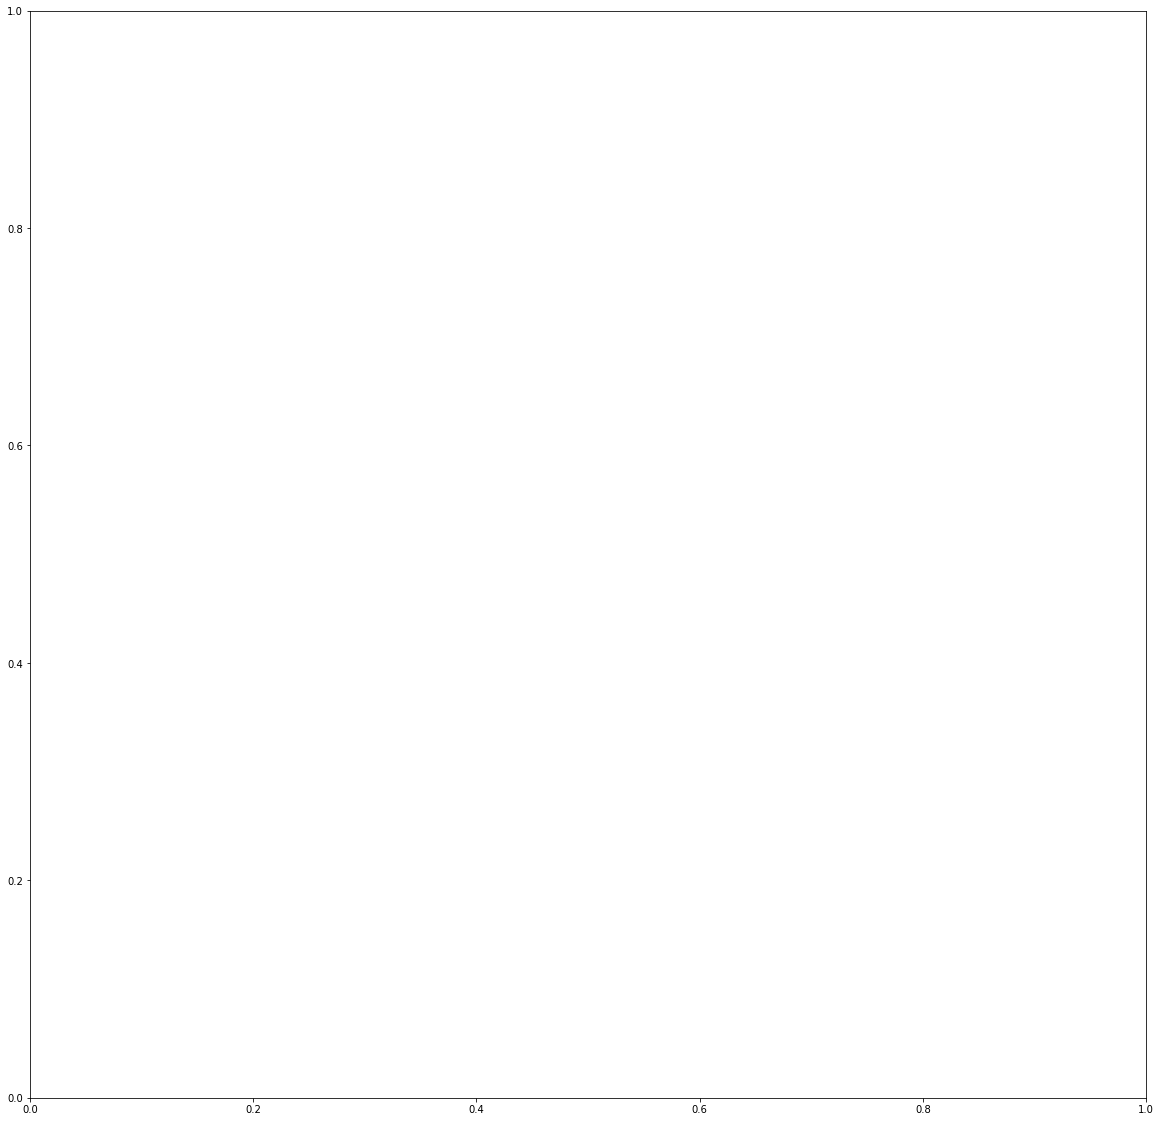

In [59]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 20))
plt.subplot(1,1,1)
image = x_img

In [60]:
image= image.astype(int)
image = np.reshape(image, (128, 128, 3))

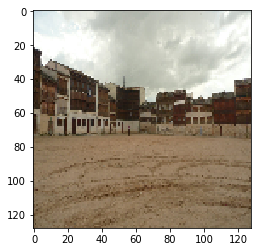

In [61]:
plt.imshow(image)

In [62]:
labels = neigh.kneighbors(features, return_distance=False) 

print(labels[0])

[1374 1428 1438 1399 1404 1432 1442 1398  139  127]


[1374 1428 1438 1399 1404 1432 1442 1398  139  127]
[1374 1428 1438 1399 1404 1432 1442 1398  139  127]
[1374 1428 1438 1399 1404 1432 1442 1398  139  127]
[1374 1428 1438 1399 1404 1432 1442 1398  139  127]
[1374 1428 1438 1399 1404 1432 1442 1398  139  127]
[1374 1428 1438 1399 1404 1432 1442 1398  139  127]
[1374 1428 1438 1399 1404 1432 1442 1398  139  127]
[1374 1428 1438 1399 1404 1432 1442 1398  139  127]
[1374 1428 1438 1399 1404 1432 1442 1398  139  127]
[1374 1428 1438 1399 1404 1432 1442 1398  139  127]


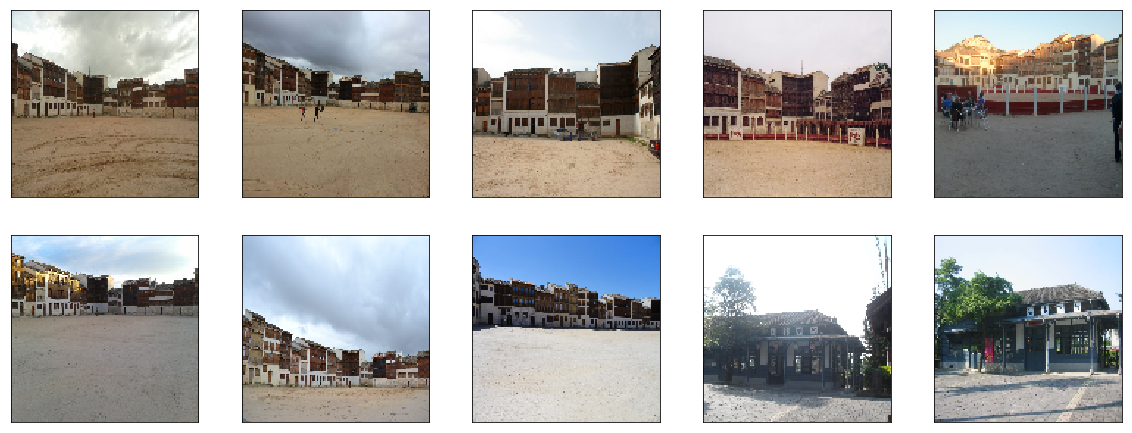

In [63]:
plt.figure(figsize=(20, 20))
for j in range(10):
    plt.subplot(5,5,j+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image = imgsList[labels[0][j]]
    image= image.astype(int)
    image = np.reshape(image, (128, 128, 3))
    plt.imshow(image)
    print(labels[0])